# Describe and extract data from a Data Resource object
---
## Learning Goals:
- Learn how to work with `describe` and `extract` functionality when handling a single `Data Resource`.
- This tutorial assumes basic knowledge of `pandas` dataframes and JSON files.
---
### Written by: Jacqueline Maasch

## Introduction

This tutorial provides a basic walk-through for the [`describe`](https://framework.frictionlessdata.io/docs/guides/describing-data/) and [`extract`](https://framework.frictionlessdata.io/docs/guides/extracting-data) functionality of the `frictionless` Python framework.

We will be working at the `Data Resource` level and exporting our metadata as a JSON file. Refer to the `frictionless` [docs](https://github.com/frictionlessdata/frictionless-py) for information on additional file types that this framework can handle.

**Why `frictionless`?** The `frictionless` framework allows us to automatically infer the metadata for our `Data Resource`, and provides diverse methods for accessing the raw data itself. Inferred metadata can easily be updated manually, and can be used to ensure consistency and quality control across multiple data resources. While automation like this is handy for a single resource, it becomes highly efficient when handling a high-throughput of data resources.

## Step 0: Installation

First, we will install `frictionless` and import the libraries that we will use. The `frictionless` library will help us describe and extract our data, `seaborn` will provide our toy data, and `pandas` will provide some convenient functionality for viewing our toy data.

In [ ]:
# Prevent output from printing to console (just for tidyness).
%%capture

# Installations.
!pip install frictionless

In [ ]:
# Importations. 
import frictionless
import seaborn as sns
import pandas as pd

## Step 1: Explore `describe` and `extract` documentation

You can invoke the documentation for a method or class by using `?` or `help()`. This is a great way to refer to docs on the fly without leaving your coding environment.

**Example:** `frictionless.describe_package?` and `help(frictionless.describe_package)` will both pull up the documentation for the method `describe_package`. 

Below, you can invoke the docs for each of the `describe` and `extract` methods that `frictionless` provides, just to get acquainted.

In [ ]:
# Invoke `describe` documentation.
help(frictionless.describe)
help(frictionless.describe_schema)
help(frictionless.describe_resource)
help(frictionless.describe_package)

Help on function describe in module frictionless.describe.main:

describe(source=None, *, type=None, **options)
    Describe the data source
    
    API      | Usage
    -------- | --------
    Public   | `from frictionless import describe`
    
    Parameters:
        source (any): data source
        type (str): source type - `schema`, `resource` or `package` (default: infer)
        **options (dict): options for the underlaying describe function
    
    Returns:
        Package|Resource|Schema: metadata

Help on function describe_schema in module frictionless.describe.schema:

describe_schema(source=None, **options)
    Describe the given source as a schema
    
    API      | Usage
    -------- | --------
    Public   | `from frictionless import describe_schema`
    
    Parameters:
        source (any): data source
        **options (dict): describe resource options
    
    Returns:
        Schema: table schema

Help on function describe_resource in module frictionless.describe

In [ ]:
# Invoke `extract` documentation.
help(frictionless.extract)
help(frictionless.extract_resource)
help(frictionless.extract_package)

Help on function extract in module frictionless.extract.main:

extract(source=None, *, type=None, process=None, stream=False, **options)
    Extract resource rows
    
    API      | Usage
    -------- | --------
    Public   | `from frictionless import extract`
    
    Parameters:
        source (dict|str): data source
        type (str): source type - package of resource (default: infer)
        process? (func): a row processor function
        stream? (bool): return a row stream(s) instead of loading into memory
        **options (dict): options for the underlaying function
    
    Returns:
        Row[]|{path: Row[]}: rows in a form depending on the source type

Help on function extract_resource in module frictionless.extract.resource:

extract_resource(source=None, *, process=None, stream=False, **options)
    Extract resource rows
    
    API      | Usage
    -------- | --------
    Public   | `from frictionless import extract_resource`
    
    Parameters:
        source (any

You can also view the documentation for the `Resource` and `Schema` classes, which we will be using below. You can do so by calling:

```python
help(frictionless.Resource)
help(frictionless.Schema)
```

## Step 2: Access and explore toy data

Many Python libraries provide access to toy datasets. Libraries that provide useful toy data for data science and machine learning include `seaborn`, `sklearn`, and `rpy2`. 

We'll be working with the `fmri` dataset from `seaborn`. This dataset contains functional magnetic resonance imaging (fMRI) data from [Waskom et al. (2017)](https://academic.oup.com/cercor/article/27/2/1270/3056315?keytype=ref&ijkey=5hjFprzQ7miiYZ4) [[GitHub]](https://github.com/mwaskom/Waskom_CerebCortex_2017), which measures changes in blood flow in different regions of the brain.

More information on `seaborn`'s toy datasets can be found [here](https://github.com/mwaskom/seaborn-data).

In [ ]:
# Load our toy dataset as a pandas dataframe.
df = sns.load_dataset("fmri")

# View our data's specs and display the first 5 rows.
print(df.info())
display(df.head())

# Export our toy data as a CSV file.
df.to_csv("fmri.csv", index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   subject    1064 non-null   object 
 1   timepoint  1064 non-null   int64  
 2   event      1064 non-null   object 
 3   region     1064 non-null   object 
 4   signal     1064 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 41.7+ KB
None


,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970


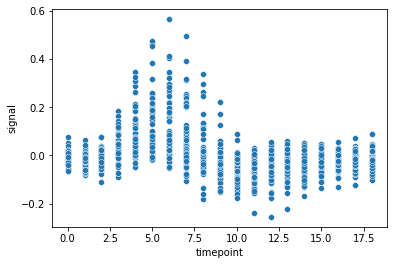

In [ ]:
# We can visaully explore our data with seaborn as well.
sns.scatterplot(x = df.timepoint, y = df.signal)

In [ ]:
# View additional available datasets.
print(sns.get_dataset_names())

['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'exercise', 'flights', 'fmri', 'gammas', 'geyser', 'iris', 'mpg', 'penguins', 'planets', 'tips', 'titanic']


## Step #3: Describe data

We are going to work at the `Data Resource` level to describe our data. An individual resource can be a single data file or tabular data structure of some kind, e.g. a CSV file.

We will generate a `Schema` object and export this as a JSON file. This JSON file will be available to view in the Google Colab sidebar.

In [ ]:
# Initialize a resource object for our toy data.
resource = frictionless.describe('fmri.csv')

# View entire resource.
print("\nRESOURCE:\n")
display(resource)
print("\n+++++++++++++++++++++++++++++++++++\n")

# View schema only.
print("SCHEMA ONLY:\n")
display(resource.schema)
print("\n+++++++++++++++++++++++++++++++++++\n")


RESOURCE:



{'encoding': 'utf-8',
 'format': 'csv',
 'hashing': 'md5',
 'name': 'fmri',
 'path': 'fmri.csv',
 'profile': 'tabular-data-resource',
 'schema': {'fields': [{'name': 'subject', 'type': 'string'},
   {'name': 'timepoint', 'type': 'integer'},
   {'name': 'event', 'type': 'string'},
   {'name': 'region', 'type': 'string'},
   {'name': 'signal', 'type': 'number'}]},
 'scheme': 'file'}


+++++++++++++++++++++++++++++++++++

SCHEMA ONLY:



{'fields': [{'name': 'subject', 'type': 'string'},
  {'name': 'timepoint', 'type': 'integer'},
  {'name': 'event', 'type': 'string'},
  {'name': 'region', 'type': 'string'},
  {'name': 'signal', 'type': 'number'}]}


+++++++++++++++++++++++++++++++++++



Curious what else your `Resource` object can do, and what other attributes describe it? Calling Python's built-in `dir()` can help you explore objects of this class by returning a list of valid attributes for a given object.

You can use this list of attributes to remind yourself of pertinent fields to update, e.g. `description`.

In [ ]:
# View the final 10 attributes of our resource object.
# Call dir(resource) to view all attributes.
print("\nSOME RESOURCE METHODS AND ATTRIBUTES:\n")
display(dir(resource)[-11:-1])
print("\n+++++++++++++++++++++++++++++++++++")

# View all headers for our resource.
print("\nDATA RESOURCE HEADERS:", 
      resource.header,
      "\n\n+++++++++++++++++++++++++++++++++++")

# Update our resource's description.
print("\nINITIAL DESCRIPTION:", 
      resource.description)
resource.description = "This dataset describes..."
print("UPDATED DESCRIPTION:", 
      resource.description,
      "\n\n+++++++++++++++++++++++++++++++++++")


SOME RESOURCE METHODS AND ATTRIBUTES:



['to_inline',
 'to_json',
 'to_pandas',
 'to_petl',
 'to_snap',
 'to_view',
 'to_yaml',
 'trusted',
 'update',
 'values']


+++++++++++++++++++++++++++++++++++

DATA RESOURCE HEADERS: ['subject', 'timepoint', 'event', 'region', 'signal'] 

+++++++++++++++++++++++++++++++++++

INITIAL DESCRIPTION: None
UPDATED DESCRIPTION: This dataset describes... 

+++++++++++++++++++++++++++++++++++


In [ ]:
# View updated resource.
print("\nUPDATED RESOURCE:\n")
display(resource)


UPDATED RESOURCE:



{'description': 'This dataset describes...',
 'encoding': 'utf-8',
 'format': 'csv',
 'hashing': 'md5',
 'name': 'fmri',
 'path': 'fmri.csv',
 'profile': 'tabular-data-resource',
 'schema': {'fields': [{'name': 'subject', 'type': 'string'},
   {'name': 'timepoint', 'type': 'integer'},
   {'name': 'event', 'type': 'string'},
   {'name': 'region', 'type': 'string'},
   {'name': 'signal', 'type': 'number'}]},
 'scheme': 'file'}

Time to export your updated resource! Check the Google Colab sidebar to access your exported JSON file.

In [ ]:
# Prevent output from printing to console (just for tidyness).
%%capture

# Export updated resource object as JSON file.
resource.to_json("resource.json")

## Step #4: Extract data

We will continue working at the `Data Resource` level to extract our data.

Note that all three methods of extraction demonstrated below will print the same output to the console. 

In [ ]:
# Extract the rows from our toy data at the dataframe level.
rows_df = frictionless.extract(df)

# Extract the rows from our toy data at the CSV level.
rows_csv = frictionless.extract("fmri.csv")

# Extract our data from the JSON file that we exported earlier.
data = frictionless.extract_resource("resource.json")

# View the first 5 rows of our extracted data.
print("\nROWS EXTRACTED FROM DATAFRAME:\n")
display(rows_df[:5])
print("\n+++++++++++++++++++++++++++++++++++")

print("\nROWS EXTRACTED FROM CSV:\n")
display(rows_csv[:5])
print("\n+++++++++++++++++++++++++++++++++++")

print("\nDATA EXTRACTED FROM JSON:\n")
display(data[:5])


ROWS EXTRACTED FROM DATAFRAME:



[{'subject': 's13', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.017551581538')},
 {'subject': 's5', 'timepoint': 14, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.0808829319505')},
 {'subject': 's12', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.0810330187333')},
 {'subject': 's11', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.04613439017519999')},
 {'subject': 's10', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.037970203264199996')}]


+++++++++++++++++++++++++++++++++++

ROWS EXTRACTED FROM CSV:



[{'subject': 's13', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.017551581538')},
 {'subject': 's5', 'timepoint': 14, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.0808829319505')},
 {'subject': 's12', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.0810330187333')},
 {'subject': 's11', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.04613439017519999')},
 {'subject': 's10', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.037970203264199996')}]


+++++++++++++++++++++++++++++++++++

DATA EXTRACTED FROM JSON:



[{'subject': 's13', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.017551581538')},
 {'subject': 's5', 'timepoint': 14, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.0808829319505')},
 {'subject': 's12', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.0810330187333')},
 {'subject': 's11', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.04613439017519999')},
 {'subject': 's10', 'timepoint': 18, 'event': 'stim', 'region': 'parietal', 'signal': Decimal('-0.037970203264199996')}]

## Conclusion
In this tutorial, you were able to access convenient toy data from the popular data visualization library `seaborn`, explore the data in `pandas`, and both describe and extract the data using `frictionless`. You worked at the `Data Resource` level to generate and update a JSON file containing your resource's metadata.

## Related Reference Documentation
Be sure to refer to the `describe` and `extract` docs for more information and additional code snippets!

- [Docs: `frictionless`](https://github.com/frictionlessdata/frictionless-py)
- [Docs: `describe`](https://framework.frictionlessdata.io/docs/guides/describing-data)
- [Docs: `extract`](https://framework.frictionlessdata.io/docs/guides/extracting-data)
- Need help? Ask us questions on [Discord](https://discord.gg/j9DNFNw)!